# Predicting Agricultural Yield for Informed Farming Decisions


# The data

Agricultural dataset 

We want to discover the relatiionships between geographic, weather, soil, and farm management features, all which afffect the prediction of crop  yield.

The goal is to decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [2]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2024-04-17 13:37:19,465 - data_ingestion - INFO - Database engine created successfully.
2024-04-17 13:37:19,596 - data_ingestion - INFO - Query executed successfully.
2024-04-17 13:37:19,596 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-04-17 13:37:19,603 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2024-04-17 13:37:20,568 - data_ingestion - INFO - CSV file read successfully from the web.


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [3]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts ==============================
platform darwin -- Python 3.11.5, pytest-7.4.0, pluggy-1.0.0 -- /Users/nyashamafumo/anaconda3/bin/python
cachedir: .pytest_cache
rootdir: /Users/nyashamafumo/Downloads/Explore_content/Regression/Regression_Exam
plugins: anyio-3.5.0
collected 4 items                                                              

validate_data.py::test_read_field_dataframe_shape PASSED                 [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                    [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED     [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                       [100%]

============================== 4 passed in 1.03s ===============================
Deleted sampled_field_df.csv


## Understanding our dataset 
In this section, we will analyse the predictor variables in our dataset and how they relate to the target variable.

In [4]:
dataset.head(10)

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,8.526684e-02,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,3.996838e-01,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,3.580286e-01,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,2.866871e-01,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,4.319027e-02,1.5,0.832614,wheat,0.555076
5,5304,850.56647,-2.050665,-7.132769,Rural_Kilimani,50.451250,649.4,-3.0,29.5,13.25,0.70,Sandy,5.484350,1.275280e-01,1.7,1.112611,potato,0.654477
6,429,331.35538,-13.409517,-6.722849,Rural_Hawassa,5.907423,1586.0,-6.8,31.8,12.50,0.63,Silt,7.061317,4.315457e-07,2.9,0.994325,banana,0.342871
7,672,790.73846,-3.785356,-1.470468,Rural_Kilimani,15.380596,1188.3,-3.0,31.0,14.00,0.63,Sandy,4.577043,6.131074e-01,1.4,0.558899,tea,0.399214
8,26124,742.72180,-10.237509,-0.736216,Rural_Sokoto,3.431843,2143.3,-2.6,28.2,12.80,0.66,Volcanic,5.447321,2.784792e-01,13.9,8.532665,coffee,0.613861
9,44050,747.38030,-3.767334,-3.105643,Rural_Kilimani,8.239554,796.6,-3.8,32.7,14.45,0.58,Sandy,4.897414,3.103862e-01,4.6,2.214679,cassava,0.481452


In [5]:
df = dataset.copy()

In [6]:
df.shape

(5654, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Field_ID           5654 non-null   int64  
 1   Elevation          5654 non-null   float64
 2   Latitude           5654 non-null   float64
 3   Longitude          5654 non-null   float64
 4   Location           5654 non-null   object 
 5   Slope              5654 non-null   float64
 6   Rainfall           5654 non-null   float64
 7   Min_temperature_C  5654 non-null   float64
 8   Max_temperature_C  5654 non-null   float64
 9   Ave_temps          5654 non-null   float64
 10  Soil_fertility     5654 non-null   float64
 11  Soil_type          5654 non-null   object 
 12  pH                 5654 non-null   float64
 13  Pollution_level    5654 non-null   float64
 14  Plot_size          5654 non-null   float64
 15  Annual_yield       5654 non-null   float64
 16  Crop_type          5654 

In [8]:
# Extract the categorical features
categorical_features = ['Location', 'Soil_type', 'Crop_type']

# Apply dummy variable encoding to the categorical features with drop_first=True
dummies = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Count the number of independent variables
num_independent_variables = dummies.shape[1]

print("Number of independent variables after dummy variable encoding:", num_independent_variables)


Number of independent variables after dummy variable encoding: 31


### Assessing correlation with target variable
 

In [9]:
dummies2 = pd.get_dummies(df, columns=categorical_features, drop_first=True, dtype = 'int')

In [10]:
dummies2.head()

,Field_ID,Elevation,Latitude,Longitude,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,...,Soil_type_Sandy,Soil_type_Silt,Soil_type_Volcanic,Crop_type_cassava,Crop_type_coffee,Crop_type_maize,Crop_type_potato,Crop_type_rice,Crop_type_tea,Crop_type_wheat
0,40734,786.05580,-7.389911,-7.556202,14.795113,1125.2,-3.1,33.1,15.00,0.62,...,1,0,0,1,0,0,0,0,0,0
1,30629,674.33410,-7.736849,-1.051539,11.374611,1450.7,-3.9,30.6,13.35,0.64,...,0,0,1,1,0,0,0,0,0,0
2,39924,826.53390,-9.926616,0.115156,11.339692,2208.9,-1.8,28.4,13.30,0.69,...,0,0,1,0,0,0,0,0,1,0
3,5754,574.94617,-2.420131,-6.592215,7.109855,328.8,-5.8,32.2,13.20,0.54,...,0,0,0,1,0,0,0,0,0,0
4,14146,886.35300,-3.055434,-7.952609,55.007656,785.2,-2.5,31.0,14.25,0.72,...,1,0,0,0,0,0,0,0,0,1


In [11]:
correlation_matrix = dummies2.corr()
correlation_target = correlation_matrix['Standard_yield'].sort_values(ascending=False)
print(correlation_target)

Standard_yield             1.000000
Crop_type_tea              0.432879
Soil_type_Volcanic         0.309982
Annual_yield               0.220812
Location_Rural_Sokoto      0.212337
Crop_type_potato           0.175484
Min_temperature_C          0.144233
Elevation                  0.129248
Crop_type_rice             0.104056
Longitude                  0.085343
Soil_fertility             0.070205
Latitude                   0.061724
Slope                      0.056991
Rainfall                   0.039217
Field_ID                   0.030802
Ave_temps                  0.006786
Crop_type_maize           -0.008100
Location_Rural_Kilimani   -0.014778
Plot_size                 -0.017014
Location_Rural_Amanzi     -0.032049
Soil_type_Rocky           -0.078355
Crop_type_wheat           -0.092420
Location_Rural_Hawassa    -0.110623
Max_temperature_C         -0.111649
Soil_type_Peaty           -0.135509
Soil_type_Sandy           -0.164714
Crop_type_cassava         -0.186716
pH                        -0

In [13]:
#For number 5
# Create a new DataFrame without the 'Field_ID' column
df_new = dummies2.drop(columns=['Field_ID'])
df_new.head(10)

,Elevation,Latitude,Longitude,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,pH,...,Soil_type_Sandy,Soil_type_Silt,Soil_type_Volcanic,Crop_type_cassava,Crop_type_coffee,Crop_type_maize,Crop_type_potato,Crop_type_rice,Crop_type_tea,Crop_type_wheat
0,786.05580,-7.389911,-7.556202,14.795113,1125.2,-3.1,33.1,15.00,0.62,6.169393,...,1,0,0,1,0,0,0,0,0,0
1,674.33410,-7.736849,-1.051539,11.374611,1450.7,-3.9,30.6,13.35,0.64,5.676648,...,0,0,1,1,0,0,0,0,0,0
2,826.53390,-9.926616,0.115156,11.339692,2208.9,-1.8,28.4,13.30,0.69,5.331993,...,0,0,1,0,0,0,0,0,1,0
3,574.94617,-2.420131,-6.592215,7.109855,328.8,-5.8,32.2,13.20,0.54,5.328150,...,0,0,0,1,0,0,0,0,0,0
4,886.35300,-3.055434,-7.952609,55.007656,785.2,-2.5,31.0,14.25,0.72,5.721234,...,1,0,0,0,0,0,0,0,0,1
5,850.56647,-2.050665,-7.132769,50.451250,649.4,-3.0,29.5,13.25,0.70,5.484350,...,1,0,0,0,0,0,1,0,0,0
6,331.35538,-13.409517,-6.722849,5.907423,1586.0,-6.8,31.8,12.50,0.63,7.061317,...,0,1,0,0,0,0,0,0,0,0
7,790.73846,-3.785356,-1.470468,15.380596,1188.3,-3.0,31.0,14.00,0.63,4.577043,...,1,0,0,0,0,0,0,0,1,0
8,742.72180,-10.237509,-0.736216,3.431843,2143.3,-2.6,28.2,12.80,0.66,5.447321,...,0,0,1,0,1,0,0,0,0,0
9,747.38030,-3.767334,-3.105643,8.239554,796.6,-3.8,32.7,14.45,0.58,4.897414,...,1,0,0,1,0,0,0,0,0,0


Here we wish to determine which of the predictors in our dataset are statistically significant. We will fit a statsmodels regression model to predict Standard_yield using our encoded dataset. Following that we will extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

In [14]:
import statsmodels.api as sm

# Extract only the relevant predictors
predictors = df_new[['Slope', 'Elevation', 'pH', 'Soil_fertility']]

# Fit the regression model
model = sm.OLS(df_new['Standard_yield'], sm.add_constant(predictors))  # Adding constant term
result = model.fit()

# Extract p-values for each predictor
p_values = result.pvalues

# Filter predictors with p-values less than 0.05
significant_predictors = p_values[p_values < 0.05]

# Display significant predictors
print("Significant predictors:")
print(significant_predictors)



Significant predictors:
const             1.796212e-63
Elevation         2.126845e-06
pH                2.153167e-29
Soil_fertility    1.153074e-06
dtype: float64


## Generating a multiple linear regression model

After encoding our variables and performing preliminary analysis, let's continue our efforts to identify the variables that will enable us to construct the most accurate multiple linear regression model possible with the data that we have.

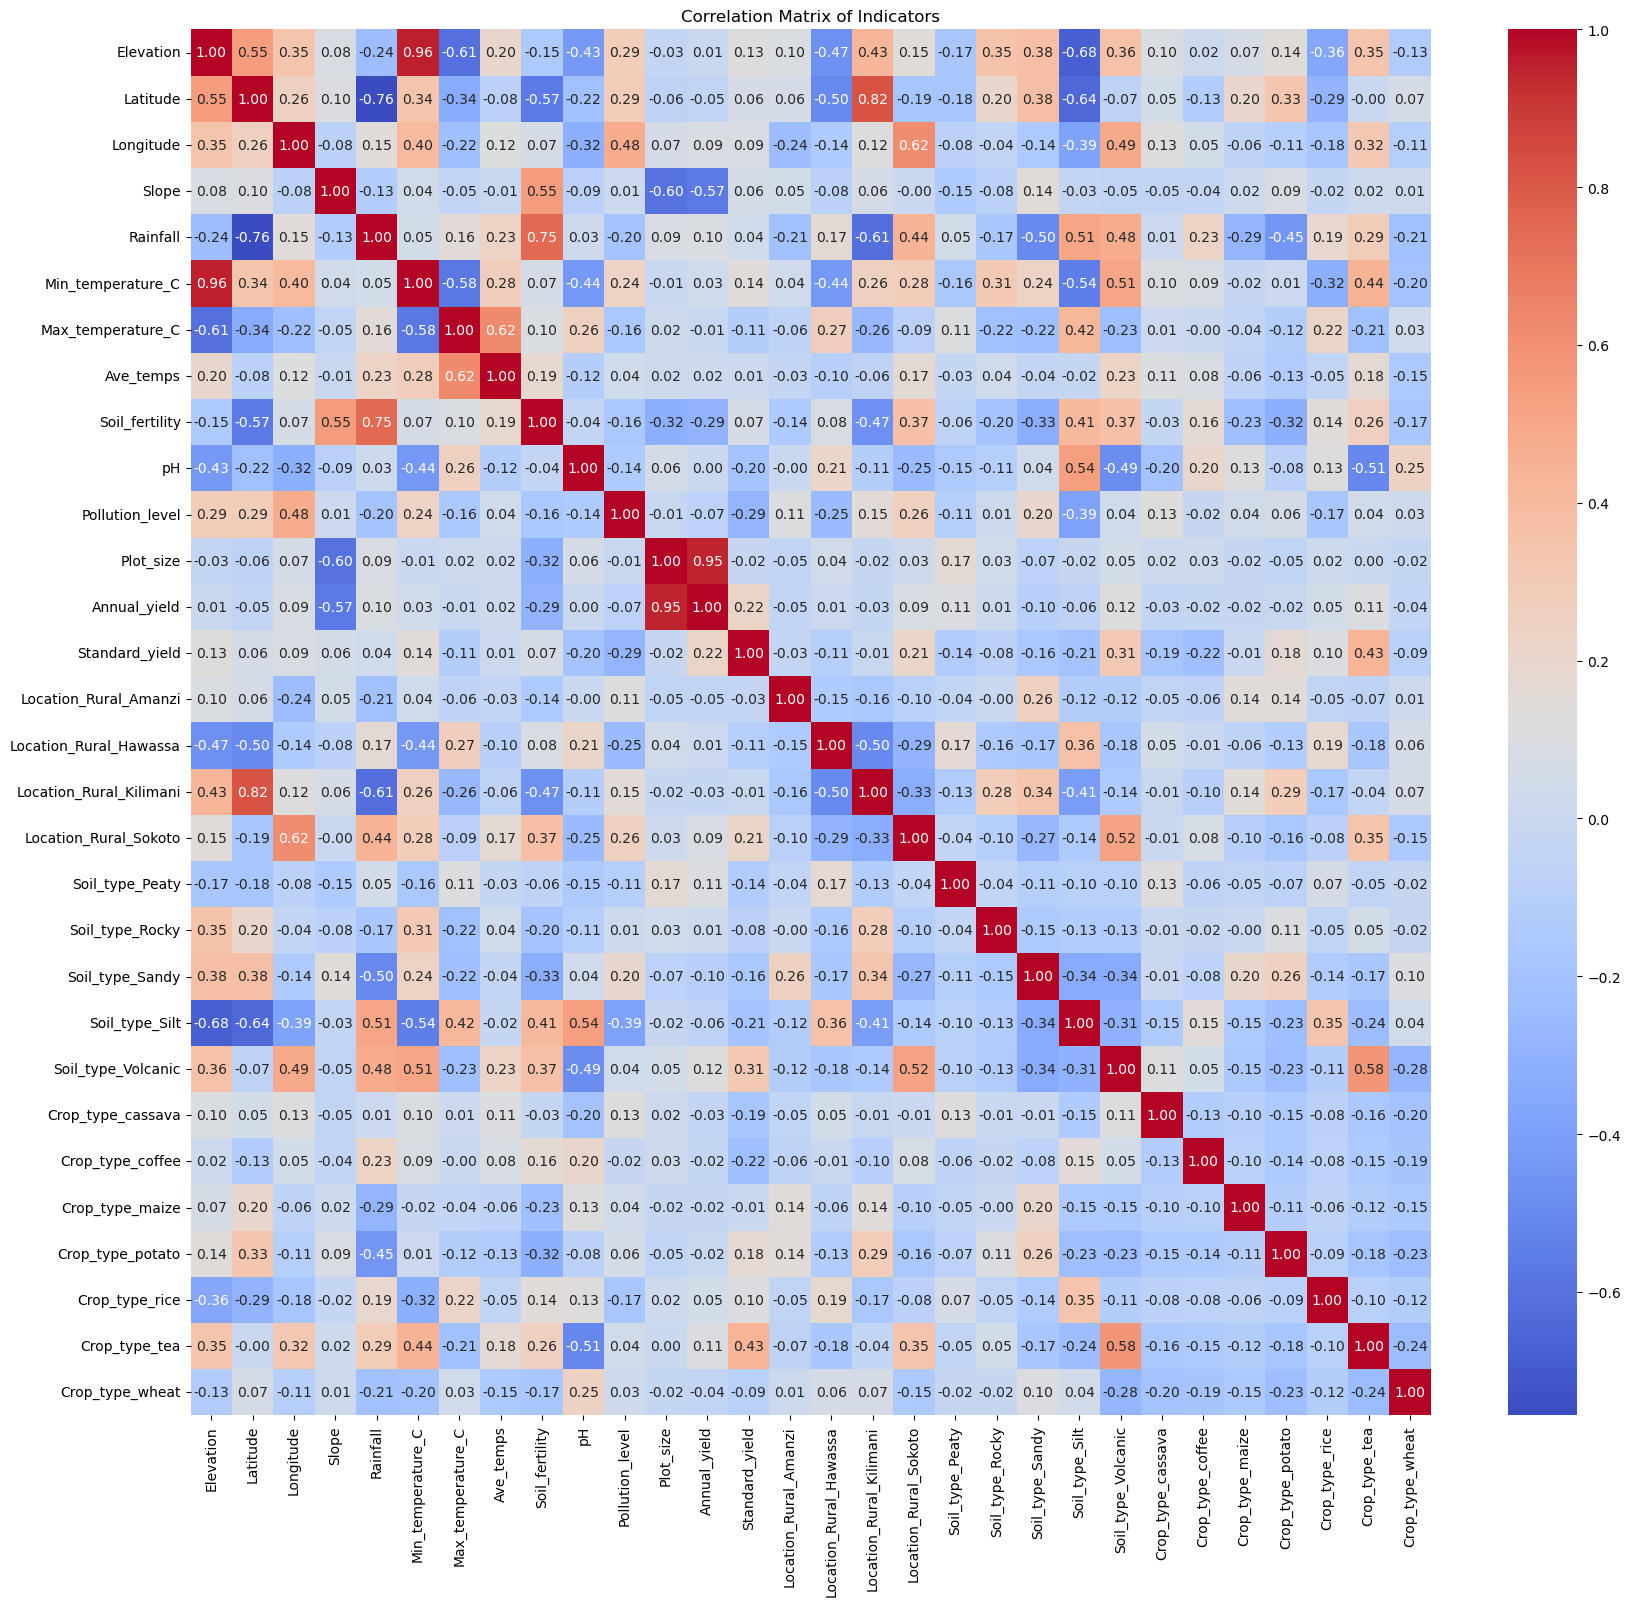

In [15]:
# Heatmap of the correlation matrix
correlation_matrix2 = df_new.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Indicators')
plt.show()

From the heatmap we see that  Elevation and Min_temperature_C have a strong correlation with one another

Now that we have analysed our variables, let's fit an ordinary least squares regression model using statsmodels.formula.api and then print the model summary. The model will be constructed using all the independent variables in our encoded dataset (excuding Field_ID).

In [16]:
from statsmodels.formula.api import ols

# The dependent variable:
y_name = 'Standard_yield'

# The independent variable
# (let's first try all of the columns in the model DataFrame)
X_names = [col for col in df_new.columns if col != y_name]

# Build the OLS formula string " y ~ X "
formula_str = y_name+" ~ "+" + ".join(X_names)

model=ols(formula=formula_str, data=df_new)
fitted = model.fit()

# Output the fitted summary
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:48:26   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.

This summary gives us an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.

To avoid this, let's reduce the number of independent variables included in our model. We will fit the model using the top seven variables that have a strong correlation to our dependent variable, namely, Crop_type_tea, Soil_type_Volcanic, Pollution_level, Crop_type_coffee, Annual_yield, Location_Rural_Sokoto and Soil_type_Silt.

In [100]:
variables = ['Pollution_level', 'Crop_type_coffee', 'Crop_type_tea', 'Location_Rural_Sokoto',
             'Annual_yield', 'Soil_type_Silt', 'Soil_type_Volcanic']

# The dependent variable:
y_name = 'Standard_yield'

formula_str = y_name + " ~ " + " + ".join(variables)

# Fit the OLS model using the specified variables from df_new
model = ols(formula=formula_str, data=df_new)
fitted = model.fit()

# Output the fitted summary
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     552.1
Date:                Sat, 06 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:11:01   Log-Likelihood:                 5839.8
No. Observations:                5654   AIC:                        -1.166e+04
Df Residuals:                    5646   BIC:                        -1.161e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.56

After reducing the number of dependent variables accordingly we see that the model improved

To evaluate our model's results. We will generate a scatter plot of the residuals against the fitted values allowing us to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.

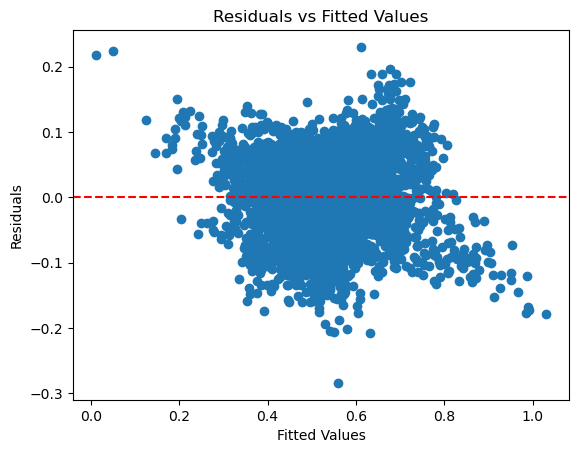

In [18]:
import matplotlib.pyplot as plt

# Obtain the residuals and fitted values
residuals = fitted.resid
fitted_values = fitted.fittedvalues

# Generate scatter plot of residuals against fitted values
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values') 
plt.axhline(y=0, color='r', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line

## Using regularisation to optimise agricultural yield

Continuing with our task, after fitting our model, we decide to go back to the drawing board to explore more ways to implement feature engineering and data pre-processing in order to optimise our model.

We suspect that, if we use all the variables available to us, the model might overfit due to the high dimensionality of the data. Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.


Our first step in the feature engineering involves creating a new feature, `Temperature_Range`, and scaling features using `StandardScaler`. The difference between `Min_temperature_C` and `Max_temperature_C` is the temperature range.


In [19]:
from sklearn.preprocessing import StandardScaler

df_new['Temperature_Range'] = df_new['Max_temperature_C'] - df_new['Min_temperature_C']

# Select features for scaling (exclude non-numeric or target variables)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialise StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_new[features])

# Show the first 5 rows of the scaled features
print(scaled_features[:5])

[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]



After this we employed LASSO regression to identify predictive features associated with our dependent variable. 5-fold cross-validation should be used to select the best regularisation parameter.


In [20]:
from sklearn.linear_model import LassoCV

# scaled_features is our matrix of scaled features and dataset['Standard_yield'] is the target variable
lasso = LassoCV(cv=5).fit(scaled_features, df_new['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]


In trying to address multicollinearity in our dataset, we also decide to implement Ridge regression.

 After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero, we decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength.


In [21]:
from sklearn.linear_model import RidgeCV

alphas=[0.001, 0.01, 0.1, 1, 10, 100]

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(scaled_features, df_new['Standard_yield'])


Given our dataset includes variables such as `Elevation` and `Slope`, and considering the potential interactions between these variables might impact crop yield, we aim to capture both these interactions and possible non-linear relationships. 

In [22]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features

poly = PolynomialFeatures(degree=2, include_bias=False)


poly_features = poly.fit_transform(df_new[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
poly_features.shape


(5654, 5)


After implementing Ridge regression to address multicollinearity and prevent overfitting in our model we need to interpret the coefficients to understand the impact of each feature on the standard yield.


In [23]:
from sklearn.linear_model import Ridge
import numpy as np

# Assuming `X` is the feature matrix and `y` is the target variable
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
ridge_model.coef_

array([-0.13661379,  0.10262221, -0.07348657])

Feature 2 ( 0.10262221) has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.

## Making a prediction using decision trees

Decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, we decide to implement a decision tree on our encoded dataset.

We will train a decision tree with the following specifications:
* Using our **previously encoded dataset**, we will split the data into dependent and independent variables using all the features except for `Standard_yield` and `Field_ID` as independent variables.
* We will then split the data into training and testing data.
* After that we will use the `DecisionTreeRegressor` to fit a model using a `max_depth' of 2 and a `random_state` of 42.

Using the trained Decision Tree Regressor model, we will make a prediction for `y` given the following x-values:<br> 
`[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,`
`16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]`

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Step 1: Split the data into dependent and independent variables
X = dummies2.drop(columns=['Standard_yield', 'Field_ID'])
y = dummies2['Standard_yield']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fit a decision tree regressor model
dt_regressor = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_regressor.fit(X_train, y_train)

# Step 4: Make predictions for the given x-values
x_values = [864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, 
            -3.4100000000000006, 36.410000000000004, 16.5, 0.682, 6.7863323423108195, 0.09379352739936421, 
            1.4300000000000002, 0.8264890400277934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1, 0.0, 0.0, 1.1, 
            0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
predicted_y = dt_regressor.predict([x_values])

# Print the predicted y-value
print("Predicted y-value:", predicted_y)

Predicted y-value: [0.48494414]


/Users/nyashamafumo/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Based on the model above, we will calculate the RMSE

In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Make predictions on the testing set
y_pred = dt_regressor.predict(X_test)

# Step 2: Compute the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Step 3: Calculate the RMSE
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.08805783663217344


An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units

Let's attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.


In [26]:
# Step 1: Split the data into dependent and independent variables
X = dummies2.drop(columns=['Standard_yield', 'Field_ID'])
y = dummies2['Standard_yield']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fit a decision tree regressor model
dt_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_regressor.fit(X_train, y_train)

# Step 4: Make predictions for the given x-values
x_values = [864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, 
            -3.4100000000000006, 36.410000000000004, 16.5, 0.682, 6.7863323423108195, 0.09379352739936421, 
            1.4300000000000002, 0.8264890400277934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1, 0.0, 0.0, 1.1, 
            0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
predicted_y = dt_regressor.predict([x_values])

# Print the predicted y-value
print("Predicted y-value:", predicted_y)

Predicted y-value: [0.49287275]


/Users/nyashamafumo/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [27]:
# Step 1: Make predictions on the testing set
y_pred = dt_regressor.predict(X_test)

# Step 2: Compute the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Step 3: Calculate the RMSE
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.06332974532698206


The decision tree model was improved by fitting it with a `max_depth` parameter of 5.

## Ensemble Methods & Bootstrapping

Using our original dataset, our objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. We'll work with a subset of features from the dataset to predict the `Standard_yield`.

The following approach will be used to implement a bootstrap aggregation (bagging) for predicting the `Standard_yield` based on features `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`. Below are the steps and part of the Python code implementing this method. 
the steps for the implementation:

1. Create an empty list named `predictions` to store predictions from each bootstrap sample.
2. Generate `n_bootstrap_samples` bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the `Standard_yield` on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = df_new[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = df_new['Standard_yield']

predictions = []
n_bootstrap_samples = 100

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)

# MISSING PART HERE
bagged_predictions = np.mean(predictions, axis=0)
mse_bagged = mean_squared_error(y, bagged_predictions)

print(f"Mean Squared Error of Bagged Linear Regression Models: {mse_bagged}")


Mean Squared Error of Bagged Linear Regression Models: 0.010840456392978762


Now lets try with a RandomForestRegressor

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialise and train the random forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

# Predict using the random forest model
y_pred_rf = rf_model.predict(X)

# Evaluate the model
mse_rf = mean_squared_error(y, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")


Mean Squared Error of Random Forest Regressor: 0.0011035129191533637


We can see that model performance improved. RandomForestRegressor might be the best model to use with our data

Now we are going to implement a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict `Standard_yield` and calculates the average Mean Squared Error (MSE) across all folds.


In [34]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialise the ridge regression model
ridge_model = Ridge()

# Perform 5-fold cross-validation with bootstrapping
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5) #add correct option here 

# Convert scores to positive MSE
mse_scores = -scores

# Calculate average MSE
average_mse = np.mean(mse_scores)
print(f"Average Mean Squared Error from Cross-Validation: {average_mse}")

Average Mean Squared Error from Cross-Validation: 0.010875483717316465


Now we want to extract and print the feature importances from a trained random forest regressor model. 

In [35]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Elevation, Importance: 0.3239346615521934
Feature: Slope, Importance: 0.21860943303336625
Feature: Soil_fertility, Importance: 0.15208746752230193
Feature: Pollution_level, Importance: 0.30536843789213847


The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict Standard_yield. Elevation and pollution seem to be very important features in yeild prediction

## Random forests
In this section, we want to test how our data fits to a random forest model and other functionalities that come with its such as analysing feature importance.

We are going to write a function named `train_rf_model` that trains and tests a random forest model on a given dataset. Our function will do the following:

* Take a `RandomForestRegressor` object (with any desired hyperparameters set) as input,
* Separate the features `X` and target `y` dataframes
* Split the data into training and testing sets - use a test size of `20%` and a random state of `42` for reproducibility
* Fit the model to the training data
* Make predictions on the testing set
* Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def train_rf_model(rf_model, X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model to the training data
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = rf_model.predict(X_test)
    
    # Calculate R-squared score
    r_squared = r2_score(y_test, y_pred)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    
    return rf_model, r_squared, mse

# Assuming rf_model is already instantiated with desired hyperparameters
# Separating features X and target y dataframes
X = df_new.drop(columns=['Standard_yield'])
y = df_new['Standard_yield']

# Instantiate the RandomForestRegressor with desired hyperparameters
rf_model = RandomForestRegressor(max_depth=200, random_state=42)

# Train the random forest model and get R-squared and MSE scores
trained_model, r_squared, mse = train_rf_model(rf_model, X, y)

# Print R-squared and MSE scores
print("R-squared Score:", r_squared)
print("Mean Squared Error (MSE):", mse)


R-squared Score: 0.9623442799361803
Mean Squared Error (MSE): 0.0005017785186433795


Following the training of our random forest models, we decide to analyse the feature importance scores provided by the model built using 200 trees. Our aim is to identify which features the model considers most significant in predicting the target variable.

In [37]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a list of tuples containing feature names and their importances
features_with_importance = [(feature, importance) for feature, importance in zip(X.columns, feature_importances)]

# Sort the list of tuples by importance (in descending order)
features_with_importance_sorted = sorted(features_with_importance, key=lambda x: x[1], reverse=True)

# Print feature importances in descending order
for feature, importance in features_with_importance_sorted:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: Rainfall, Importance: 0.20048531482882073
Feature: Crop_type_tea, Importance: 0.18324261984539017
Feature: Latitude, Importance: 0.1542256040312469
Feature: pH, Importance: 0.12056994081076317
Feature: Elevation, Importance: 0.07788569110480281
Feature: Pollution_level, Importance: 0.0642488224852032
Feature: Crop_type_rice, Importance: 0.04088934219755794
Feature: Crop_type_coffee, Importance: 0.03933176806499603
Feature: Crop_type_potato, Importance: 0.026012605684815514
Feature: Crop_type_wheat, Importance: 0.021689072229879272
Feature: Min_temperature_C, Importance: 0.017570672977397478
Feature: Longitude, Importance: 0.01015115296639734
Feature: Crop_type_cassava, Importance: 0.0076921208945699105
Feature: Annual_yield, Importance: 0.0058214962940323035
Feature: Soil_type_Sandy, Importance: 0.004370869815285613
Feature: Soil_type_Volcanic, Importance: 0.0043031927895241795
Feature: Temperature_Range, Importance: 0.0035836516107053467
Feature: Plot_size, Importance: 0.0031

The top 3 most significant features in predicting Standard_yield are Rainfall, Crop_type_tea, Latitude. 

 From our analysis we see that Random forests will be the best model to implement in predicting crop yield. From the analysis we also see that  Rainfall, Crop_type_tea, and Latitude contribute greatly in predicting yield.

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>